# Project II: Dynamic Programming

### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import ttest_1samp
%matplotlib inline

### Plotting Styles

In [2]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['lines.linewidth'] = 0.6
plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight')
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Step 1

Assume there are 365 days until the plane departs, so you have 365 opportunities to sell tickets,
after that people either show up or not to the flight. There are 100 seats in coach and 20 seats
in first-class. Each coach ticket holder shows up to the flight with probability 95%, and each
first-class ticket holder shows up to the flight with probability 97%. You can charge $300 or
$350 for coach tickets, and you can charge $425 or $500 for first-class tickets. On each day, if
the price is $300 for coach there is a 65% chance a coach ticket is sold, if the price is $350 for
coach there is a 30% chance a coach ticket is sold, if the price is $425 for first-class there is an
8% chance a first-class ticket is sold, and if the price is $500 for first-class there is a 4% chance a
first-class ticket is sold. For the first iteration, examine the expected discounted revenue when
you allow coach to be oversold by 5 seats. It costs the airline $50 to bump a coach passenger to
first-class and it costs the airline $425 to bump a coach passenger off the plane. The discount
rate is 17% per year, so the daily discount factor is 1/(1+0.17/365). What is the expected
discounted profit of selling these tickets and paying out overbooking costs over the course of
the year?
- On the day the flight takes off there is no revenue, only costs. You can calculate the
expected cost using the binomial distribution (scipy.stats.binom.pmf), where the
number of trials is the number of tickets sold, and a success is if a passenger shows up
for the flight.
- Remember, when first-class is sold out if the coach price is $300, then the chance of a
sale increases from 65% to 68%, and if the coach price is $350 then the chance of a sale
increases from 30% to 33%

### **Dynamic Programming Fundamentals**

**State Variables:** 
(t, c, f)
- t: time from 0 - 365 (plane takes off)
- c: number of coach seats sold
- f: number of first-class seats sold

**Choice Variables:** 
(price coach, price first-class)
- H, H
- H, L
- L, H
- L, L

**Dynamics:** 
- HH Dynamics: 
    - No sell, No sell: (t, c, f) -> (t+1, c, f) w.p. (0.7)*(0.96) = 0.672
    - Sell, No sell: (t, c, f) -> (t+1, c+1, f) w.p. (0.3)*(0.96) = 0.288
    - No sell, Sell: (t, c, f) -> (t+1, c, f+1) w.p. (0.7)*(0.04) = 0.028
    - Sell, Sell: (t, c, f) -> (t+1, c+1, f+1) w.p. (0.3)*(0.04) = 0.012
- HL Dynamics: 
    - No sell, No sell: (t, c, f) -> (t+1, c, f) w.p. (0.7)*(0.92) = 0.644
    - Sell, No sell: (t, c, f) -> (t+1, c+1, f) w.p. (0.3)*(0.92) = 0.276
    - No sell, Sell: (t, c, f) -> (t+1, c, f+1) w.p. (0.7)*(0.08) = 0.056
    - Sell, Sell: (t, c, f) -> (t+1, c+1, f+1) w.p. (0.3)*(0.08) = 0.024
- LH Dynamics: 
    - No sell, No sell: (t, c, f) -> (t+1, c, f) w.p. (0.35)*(0.96) = 0.336
    - Sell, No sell: (t, c, f) -> (t+1, c+1, f) w.p. (0.65)*(0.96) = 0.624
    - No sell, Sell: (t, c, f) -> (t+1, c, f+1) w.p. (0.35)*(0.04) = 0.014
    - Sell, Sell: (t, c, f) -> (t+1, c+1, f+1) w.p. (0.65)*(0.04) = 0.026
- LL Dynamics: 
    - No sell, No sell: (t, c, f) -> (t+1, c, f) w.p. (0.35)*(0.92) = 0.322
    - Sell, No sell: (t, c, f) -> (t+1, c+1, f) w.p. (0.65)*(0.92) = 0.598
    - No sell, Sell: (t, c, f) -> (t+1, c, f+1) w.p. (0.35)*(0.08) = 0.028
    - Sell, Sell: (t, c, f) -> (t+1, c+1, f+1) w.p. (0.65)*(0.08) = 0.052

**Value Function:**
$$V(t, c, f) = \max_{Price} \ \ E[\ \sum_{i = 0}^{T - t}(profit\ @\  t\  + \ i) * \delta^i\ ]$$

**Bellman Equation:** 
$$V(t,c,f) = \max_{Price} \ \ [E[\ revenue\ today\ ] + \ \delta\ E[\ V (tomorrow)] \ if\ HH,\ E[\ revenue\ today\ ] + \ \delta\ E[\ V (tomorrow)] \ if\ HL, \\
E[\ revenue\ today\ ] + \ \delta\ E[\ V (tomorrow)] \ if\ LH,\ E[\ revenue\ today\ ] + \ \delta\ E[\ V (tomorrow)] \ if\ LL ]$$

**Terminal Condition:** 
$$V(365, c, f) = -E[cost \ given\ c\ seats\ sold\ and\ f\  seats\ sold]$$
$$V(365, c, f) = -\sum_{i = 0}^{c} \sum_{j = 0}^{f}\ (cost\ of\ i,j\ showing\ up)\ *\ (probability\ of\ i,j\ showing\ up)$$
$$V(365, c, f) = -\sum_{i = 0}^{c} \sum_{j = 0}^{f}\ (cost\ of\ i,j\ showing\ up)\ *\ (probability\ of\ i\ showing\ up\ if\ c\ sold)\ *\ (probability\ of\ j\ showing\ up\ if\ f\ sold)$$

In [3]:
# Define variables 

# Time
T = 365

# Coach variables 
num_coach = 100
coach_low = 300
coach_high = 350
prob_coach_show = 0.95
prob_coach_low = [0.65, 0.35]  # prob sell, prob no sell
prob_coach_high = [0.3, 0.7]   # prob sell, prob no sell

# First-class variables
num_first = 20
first_low = 425 
first_high = 500
prob_first_show = 0.97
prob_first_low = [0.08, 0.92]  # prob sell, prob no sell
prob_first_high = [0.04, 0.96] # prob sell, prob no sell

# Oversell limit
coach_oversell = 5

# Airline costs
cost_upgrade = 50
cost_bump_off = 425

# Discount rate (daily)
annual_discount_rate = 0.17
delta = 1/(1 + annual_discount_rate/365)

# when first-class is sold out, the chance of a sale in coach increases by 3 percentage points
# regardless of the coach
prob_coach_low_first_out = [0.68, 0.32]    # prob sell, prob no sell
prob_coach_high_first_out = [0.33, 0.67]   # prob sell, prob no sell

In [4]:
# Function to solve method one - Static policy

def solve_expected_profit(coach_oversell) : 
   
    # Time, coach, and first class values
    coachValues = np.arange(num_coach + coach_oversell + 1) # possible # coach seats sold (0, 1, 2,...,100 + oversell)
    firstValues = np.arange(num_first + 1)                  # possible # first-class seats sold (0, 1, 2,...20)
    tValues = np.arange(T + 1)                              # possible days until takeoff (0, 1, 2...365)

    coachN = len(coachValues) # count possible state values
    firstN = len(firstValues)
    tN = len(tValues)

    # Establish value function array (V) and optimal choice array (U)
    V = np.zeros((tN, coachN, firstN)) # initialize value function
    U = np.zeros((tN, coachN, firstN)) # initialize optimal choice variable; best price to choose

    # Terminal condition (T = 365)
    # on the last day, there is no revenue to gain, just costs to face

    for c in range(coachN):
        for f in range(firstN):
            expected_cost = 0
            for i in range(c + 1):
                for j in range(f + 1):
                    # initialize cost, number oversold coach seats, and number of first class seats left
                    cost = 0
                    num_oversold = 0
                    first_class_left = num_first - j

                    # if the airline oversold
                    if i > num_coach:
                        # calculate the number of oversold seats
                        num_oversold = i - num_coach
                        # for each oversold seat, transfer to first class if possible, else bump off
                        for value in range(num_oversold):
                            if first_class_left > 0:
                                cost += cost_upgrade
                                first_class_left -= 1
                            else:
                                cost += cost_bump_off

                        # calculate probability of i showing up if c sold
                        prob_coach = binom.pmf(i, c, prob_coach_show)

                        # calculate probability of j showing up if f sold
                        prob_first = binom.pmf(j, f, prob_first_show)

                        # calculate expected cost
                        expected_cost += prob_coach * prob_first * cost 
                    
            # add -1 * expected cost to V array for that c, f combination
            V[T, c, f] = -1 * expected_cost


    # Solve problem backwards in time using the Bellman equation

    for t in reversed(range(tN-1)):     # loop back in time
        for c in range(coachN):         # loop thru all possible coach seats available; 0,1,2,...100 seats available
            for f in range(firstN):     # loop thru all possible first-class seats available; 0,1,2,...20 seats available

                # case 1: coach unavailable, first class unavailable
                if c == num_coach + coach_oversell and f == num_first:
                    V[t, c, f]  = 0 + delta * V[t + 1, c, f]        # no revenue today, but discount future revenue
                    U[t, c, f] = 0                                  # can't sell anything today

                # case 2: coach unavailable, first class available
                elif c == num_coach + coach_oversell and f < num_first:
                    # expected revenue today
                    value_high_first_er = (first_high) * 1 * prob_first_high[0] + 0 * 1 * prob_first_high[1]        # no sale/sale or no sale/no sale
                    value_low_first_er = (first_low) * 1 * prob_first_low[0] + 0 * 1 * prob_first_low[1]            # no sale/sale or no sale/no sale

                    # expected value tomorrow
                    value_high_first_tom = delta * ( 1 * prob_first_high[0] * V[t + 1, c, f + 1] + 1 * prob_first_high[1] * V[t + 1, c, f] )        # no sale/sale or no sale/no sale
                    value_low_first_tom = delta * ( 1 * prob_first_low[0] * V[t + 1, c, f + 1] + 1 * prob_first_low[1] * V[t + 1, c, f] )           # no sale/sale or no sale/no sale

                    # combine value functions
                    value_high_first = value_high_first_er + value_high_first_tom
                    value_low_first = value_low_first_er + value_low_first_tom

                    V[t, c, f] = max(value_high_first, value_low_first)               # choose the best value function
                    U[t, c, f] = np.argmax([value_high_first, value_low_first]) + 5   # 5 will be HF ONLY, 6 will be LF ONLY    
                    

                # case 3: coach available, first class unavailable
                elif c < num_coach + coach_oversell and f == num_first:
                    # expected revenue today
                    value_high_coach_er = (coach_high) * prob_coach_high_first_out[0] * 1 + 0 * prob_coach_high_first_out[1] * 1        # sale/no sale or no sale/no sale
                    value_low_coach_er = (coach_low) * prob_coach_low_first_out[0] * 1 + 0 * prob_coach_low_first_out[1] * 1            # sale/no sale or no sale/no sale

                    # expected value tomorrow
                    value_high_coach_tom = delta * ( prob_coach_high_first_out[0] * 1 * V[t + 1, c + 1, f] + prob_coach_high_first_out[1] * 1 * V[t + 1, c, f] )
                    value_low_coach_tom = delta * ( prob_coach_low_first_out[0] * 1 * V[t + 1, c + 1, f] + prob_coach_low_first_out[1] * 1 * V[t + 1, c, f] )

                    # combine value functions
                    value_high_coach = value_high_coach_er + value_high_coach_tom
                    value_low_coach = value_low_coach_er + value_low_coach_tom

                    V[t, c, f] = max(value_high_coach, value_low_coach)               # choose the best value function
                    U[t, c, f] = np.argmax([value_high_coach, value_low_coach]) + 7   # 7 will be HC ONLY, 8 will be LC ONLY


                # case 4: coach available, first class available
                else:
                    # expected revenue today
                    # order is sale/sale, sale/no sale, no sale/sale, no sale/no sale
                    valueHH_er = (coach_high + first_high) * prob_coach_high[0] * prob_first_high[0] + (coach_high) * prob_coach_high[0] * prob_first_high[1] + (first_high) * prob_coach_high[1] * prob_first_high[0] + 0 * prob_coach_high[1] * prob_first_high[1]
                    valueHL_er = (coach_high + first_low) * prob_coach_high[0] * prob_first_low[0] + (coach_high) * prob_coach_high[0] * prob_first_low[1] + (first_low) * prob_coach_high[1] * prob_first_low[0] + 0 * prob_coach_high[1] * prob_first_low[1]
                    valueLH_er = (coach_low + first_high) * prob_coach_low[0] * prob_first_high[0] + (coach_low) * prob_coach_low[0] * prob_first_high[1] + (first_high) * prob_coach_low[1] * prob_first_high[0] + 0 * prob_coach_low[1] * prob_first_high[1]
                    valueLL_er = (coach_low + first_low) * prob_coach_low[0] * prob_first_low[0] + (coach_low) * prob_coach_low[0] * prob_first_low[1] + (first_low) * prob_coach_low[1] * prob_first_low[0] + 0 * prob_coach_low[1] * prob_first_low[1]

                    # expected value function tomorrow
                    # order is sale/sale, sale/no sale, no sale/sale, no sale/no sale
                    valueHH_tom = delta * ( (prob_coach_high[0] * prob_first_high[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_high[0] * prob_first_high[1] * V[t + 1, c + 1, f]) + (prob_coach_high[1] * prob_first_high[0] * V[t + 1, c, f + 1]) + (prob_coach_high[1] * prob_first_high[1] * V[t + 1, c, f]) )
                    valueHL_tom = delta * ( (prob_coach_high[0] * prob_first_low[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_high[0] * prob_first_low[1] * V[t + 1, c + 1, f]) + (prob_coach_high[1] * prob_first_low[0] * V[t + 1, c, f + 1]) + (prob_coach_high[1] * prob_first_low[1] * V[t + 1, c, f]) )
                    valueLH_tom = delta * ( (prob_coach_low[0] * prob_first_high[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_low[0] * prob_first_high[1] * V[t + 1, c + 1, f]) + (prob_coach_low[1] * prob_first_high[0] * V[t + 1, c, f + 1]) + (prob_coach_low[1] * prob_first_high[1] * V[t + 1, c, f]) )
                    valueLL_tom = delta * ( (prob_coach_low[0] * prob_first_low[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_low[0] * prob_first_low[1] * V[t + 1, c + 1, f]) + (prob_coach_low[1] * prob_first_low[0] * V[t + 1, c, f + 1]) + (prob_coach_low[1] * prob_first_low[1] * V[t + 1, c, f]) )

                    # combine value functions
                    valueHH = valueHH_er + valueHH_tom
                    valueHL = valueHL_er + valueHL_tom
                    valueLH = valueLH_er + valueLH_tom
                    valueLL = valueLL_er + valueLL_tom

                    V[t, c, f] = max(valueHH, valueHL, valueLH, valueLL)                    # value funciton maximizes expected profit
                    U[t, c, f] = np.argmax([valueHH, valueHL, valueLH, valueLL]) + 1        # HH:1, HL:2, LH:3, LL:4


    # compute expected profit
    expected_profit = round(V[0,0,0], 2)

    return V, U, expected_profit

In [5]:
# solve with 5 coach oversell limit
V, U, expected_profit = solve_expected_profit(5)

print("Expected profit with 5 coach seats oversold: $", expected_profit, sep = '')

Expected profit with 5 coach seats oversold: $41886.16


Key for U Matrix (Static Policy): 
- 1: HH
- 2: HL
- 3: LH
- 4: LL
- 5: HF ONLY
- 6: LF ONLY
- 7: HC ONLY
- 8: LC ONLY


## Step 2

Repeat Step 1 while allowing coach to be oversold by 6, 7, 8, ... 15 seats. Which overbooking policy leads to the largest profits by the airline?

In [6]:
seats_oversold = range(5, 16)

# loop through different oversell limits and compute expected profit
expected_profit_dict = {}
print("Method 1 - Static Overbooking Solution\n")
for seat in seats_oversold: 
    V, U, expected_profit = solve_expected_profit(seat)
    expected_profit_dict[seat] = expected_profit
    print("Expected profit with ", seat, " coach seats oversold: $", expected_profit, sep = '')

Method 1 - Static Overbooking Solution

Expected profit with 5 coach seats oversold: $41886.16
Expected profit with 6 coach seats oversold: $42011.22
Expected profit with 7 coach seats oversold: $42085.54
Expected profit with 8 coach seats oversold: $42122.17
Expected profit with 9 coach seats oversold: $42134.62
Expected profit with 10 coach seats oversold: $42132.9
Expected profit with 11 coach seats oversold: $42123.67
Expected profit with 12 coach seats oversold: $42111.03
Expected profit with 13 coach seats oversold: $42097.42
Expected profit with 14 coach seats oversold: $42084.11
Expected profit with 15 coach seats oversold: $42071.74


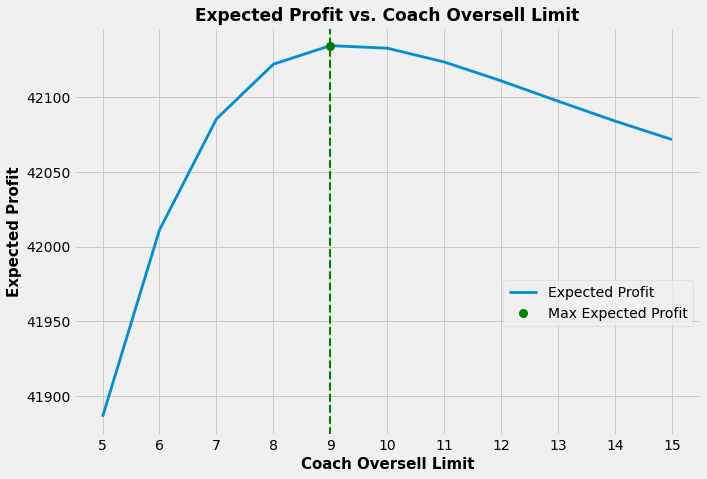

In [7]:
# plot expected profit vs. oversell limit
plt.rcParams["figure.figsize"] = (10, 7)
plt.plot(seats_oversold, list(expected_profit_dict.values()), linewidth = 2.8)
plt.xticks(np.arange(5, 16, 1.0))
max_expected_profit = max(expected_profit_dict.values())
max_expected_profit_key = max(expected_profit_dict, key = expected_profit_dict.get)
plt.plot(max_expected_profit_key, max_expected_profit, 'go', markersize = 8)
plt.axvline(x = max_expected_profit_key, color = 'green', linestyle = '--', linewidth = 2.1)
plt.legend(["Expected Profit", "Max Expected Profit"], loc = "lower right", bbox_to_anchor = (1.0, 0.25))
plt.xlabel("Coach Oversell Limit")
plt.ylabel("Expected Profit")
plt.title("Expected Profit vs. Coach Oversell Limit")
plt.show()

In [8]:
# use the expected_profit_dict, find the highest profit value and corresponding num oversold
max_expected_profit = max(expected_profit_dict.values())
max_expected_profit_key = max(expected_profit_dict, key = expected_profit_dict.get)

print("The maximum expected profit is $", max_expected_profit, " by allowing ", max_expected_profit_key, " coach seats to be oversold.", sep = '')

The maximum expected profit is $42134.62 by allowing 9 coach seats to be oversold.


In [9]:
# save off the U and V matrix of optimal static solution 
V_static_opt, U_static_opt, expected_profit_U_opt = solve_expected_profit(max_expected_profit_key)

In [10]:
U_static_opt.shape

(366, 110, 21)

In [11]:
# compute expected profit in static solution when coach_oversell = 0
V_static_0, U_static_0, profit_static_0 = solve_expected_profit(0)
print("The expected profit is: $", profit_static_0, sep = '')
print("Difference: $", round(expected_profit_U_opt - profit_static_0, 2), sep = '')
print("Percent change: ", round((expected_profit_U_opt - profit_static_0)/profit_static_0 * 100, 2), "%", sep = '')

The expected profit is: $40654.29
Difference: $1480.33
Percent change: 3.64%


## Step 3

Compare the previous policy, where there is a hard cap on seats sold, to another strategy where
there is a third choice on each day when you’re deciding ticket prices. Consider a new policy
that allows the airline to choose to sell no coach tickets on a day if it wants; the airline has the
option to force demand to 0 on a day. Now there are 3 choices each day for coach: high price,
low price, and no sale. There are still just 2 choices each day for first class: high and low price.
Assume that the airline will never sell more than 120 seats in coach, but on any one day they
can choose to not sell coach tickets. This way they can stop over-selling tickets not just based
on how many they have sold, but also on how many days are left to sell. Does this policy have a
better or worse expected profit than the best policy from step 2?

In [12]:
# Define variables 

# Time
T = 365

# Coach variables 
num_coach = 100
coach_low = 300
coach_high = 350
prob_coach_show = 0.95
prob_coach_low = [0.65, 0.35]  # prob sell, prob no sell
prob_coach_high = [0.3, 0.7]   # prob sell, prob no sell

# First-class variables
num_first = 20
first_low = 425 
first_high = 500
prob_first_show = 0.97
prob_first_low = [0.08, 0.92]  # prob sell, prob no sell
prob_first_high = [0.04, 0.96] # prob sell, prob no sell

# Oversell limit
coach_oversell = 5

# Airline costs
cost_upgrade = 50
cost_bump_off = 425

# Discount rate (daily)
annual_discount_rate = 0.17
delta = 1/(1 + annual_discount_rate/365)

# when first-class is sold out, the chance of a sale in coach increases by 3 percentage points
# regardless of the coach
prob_coach_low_first_out = [0.68, 0.32]    # prob sell, prob no sell
prob_coach_high_first_out = [0.33, 0.67]   # prob sell, prob no sell

In [13]:
# function for method 2 (ability to sell no coach seats in a day)

def solve_expected_profit_zero_coach(coach_oversell): 
   
    # Time, coach, and first class values
    coachValues = np.arange(num_coach + coach_oversell + 1)  # all possible number of coach seats sold (0, 1, 2, ...100 + overflow)
    firstValues = np.arange(num_first + 1)                   # all possible number of first seats sold (0, 1, 2,...20)
    tValues = np.arange(T + 1)                               # all possible days until takeoff (0, 1, 2...365)

    coachN = len(coachValues)  # count possible state values
    firstN = len(firstValues)
    tN = len(tValues)

    # Establish value function array (V) and optimal choice array (U)
    V = np.zeros((tN, coachN, firstN)) # initialize value function
    U = np.zeros((tN, coachN, firstN)) # initialize optimal choice variable; best price to choose

    # Terminal condition (T = 365)

    # on the last day, there is revenue to gain, just costs to face
    for c in range(coachN):
        for f in range(firstN):
            expected_cost = 0
            for i in range(c + 1):
                for j in range(f + 1):
                    # initialize cost, number oversold coach seats, and number of first class seats left
                    cost = 0
                    num_oversold = 0
                    first_class_left = num_first - j

                    # if the airline oversold
                    if i > num_coach:
                        # calculate the number of oversold seats
                        num_oversold = i - num_coach
                        # for each oversold seat, transfer to first class if possible, else bump off
                        for value in range(num_oversold):
                            if first_class_left > 0:
                                cost += cost_upgrade
                                first_class_left -= 1
                            else:
                                cost += cost_bump_off

                        # calculate probability of i showing up if c sold
                        prob_coach = binom.pmf(i, c, prob_coach_show)

                        # calculate probability of j showing up if f sold
                        prob_first = binom.pmf(j, f, prob_first_show)

                        # calculate expected cost
                        expected_cost += prob_coach * prob_first * cost 
                    
            # add -1 * expected cost to V array for that c, f combination
            V[T, c, f] = -1 * expected_cost


    # Solve problem backwards in time using the Bellman equation

    for t in reversed(range(tN-1)):      # loop back in time
        for c in range(coachN):          # loop thru all possible coach seats available; 0,1,2,...100 seats available
            for f in range(firstN):      # loop thru all possible first-class seats available; 0,1,2,...20 seats available

                # case 1: coach unavailable, first class unavailable - No Choices
                if c == num_coach + coach_oversell and f == num_first:
                    V[t, c, f]  = 0 + delta * V[t + 1, c, f]        # no revenue today, but discount future revenue
                    U[t, c, f] = 0                                  # can't sell anything today

                # case 2: coach unavailable, first class available - High First, Low First
                elif c == num_coach + coach_oversell and f < num_first:
                    # expected revenue today
                    value_high_first_er = (first_high) * 1 * prob_first_high[0] + 0 * 1 * prob_first_high[1]        # no sale/sale or no sale/no sale
                    value_low_first_er = (first_low) * 1 * prob_first_low[0] + 0 * 1 * prob_first_low[1]            # no sale/sale or no sale/no sale

                    # expected value tomorrow
                    value_high_first_tom = delta * ( 1 * prob_first_high[0] * V[t + 1, c, f + 1] + 1 * prob_first_high[1] * V[t + 1, c, f] )        # no sale/sale or no sale/no sale
                    value_low_first_tom = delta * ( 1 * prob_first_low[0] * V[t + 1, c, f + 1] + 1 * prob_first_low[1] * V[t + 1, c, f] )           # no sale/sale or no sale/no sale

                    # combine value functions
                    value_high_first = value_high_first_er + value_high_first_tom
                    value_low_first = value_low_first_er + value_low_first_tom

                    V[t, c, f] = max(value_high_first, value_low_first)               # choose the best value function
                    U[t, c, f] = np.argmax([value_high_first, value_low_first]) + 7   # 7 will be HF ONLY, 8 will be LF ONLY    
                    

                # case 3: coach available, first class unavailable - No Coach, High Coach, Low Coach
                elif c < num_coach + coach_oversell and f == num_first:
                    # expected revenue today
                    value_high_coach_er = (coach_high) * prob_coach_high_first_out[0] * 1 + 0 * prob_coach_high_first_out[1] * 1        # sale/no sale or no sale/no sale
                    value_low_coach_er = (coach_low) * prob_coach_low_first_out[0] * 1 + 0 * prob_coach_low_first_out[1] * 1            # sale/no sale or no sale/no sale
                    value_no_coach_er = 0 

                    # expected value tomorrow
                    value_high_coach_tom = delta * ( prob_coach_high_first_out[0] * 1 * V[t + 1, c + 1, f] + prob_coach_high_first_out[1] * 1 * V[t + 1, c, f] )
                    value_low_coach_tom = delta * ( prob_coach_low_first_out[0] * 1 * V[t + 1, c + 1, f] + prob_coach_low_first_out[1] * 1 * V[t + 1, c, f] )
                    value_no_coach_tom = delta * V[t + 1, c, f]

                    # combine value functions
                    value_high_coach = value_high_coach_er + value_high_coach_tom
                    value_low_coach = value_low_coach_er + value_low_coach_tom
                    value_no_coach = value_no_coach_er + value_no_coach_tom

                    V[t, c, f] = max(value_high_coach, value_low_coach, value_no_coach)                 # choose the best value function
                    U[t, c, f] = np.argmax([value_high_coach, value_low_coach, value_no_coach]) + 9     # 9 is HC ONLY, 10 is LC ONLY, 11 is NC ONLY


                # case 4: coach available, first class available - All 6 choices
                else:
                    # expected revenue today
                    # order is sale/sale, sale/no sale, no sale/sale, no sale/no sale
                    valueHH_er = (coach_high + first_high) * prob_coach_high[0] * prob_first_high[0] + (coach_high) * prob_coach_high[0] * prob_first_high[1] + (first_high) * prob_coach_high[1] * prob_first_high[0] + 0 * prob_coach_high[1] * prob_first_high[1]
                    valueHL_er = (coach_high + first_low) * prob_coach_high[0] * prob_first_low[0] + (coach_high) * prob_coach_high[0] * prob_first_low[1] + (first_low) * prob_coach_high[1] * prob_first_low[0] + 0 * prob_coach_high[1] * prob_first_low[1]
                    valueLH_er = (coach_low + first_high) * prob_coach_low[0] * prob_first_high[0] + (coach_low) * prob_coach_low[0] * prob_first_high[1] + (first_high) * prob_coach_low[1] * prob_first_high[0] + 0 * prob_coach_low[1] * prob_first_high[1]
                    valueLL_er = (coach_low + first_low) * prob_coach_low[0] * prob_first_low[0] + (coach_low) * prob_coach_low[0] * prob_first_low[1] + (first_low) * prob_coach_low[1] * prob_first_low[0] + 0 * prob_coach_low[1] * prob_first_low[1]
                    valueNH_er = (first_high) * 1 * prob_first_high[0] + 0 * 1 * prob_first_high[1]  # no sale/sale and no sale/no sale only because forcing coach demand to 0
                    valueNL_er = (first_low) * 1 * prob_first_low[0] + 0 * 1 * prob_first_low[1]    # no sale/sale and no sale/no sale only because forcing coach demand to 0

                    # expected value function tomorrow
                    # order is sale/sale, sale/no sale, no sale/sale, no sale/no sale
                    valueHH_tom = delta * ( (prob_coach_high[0] * prob_first_high[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_high[0] * prob_first_high[1] * V[t + 1, c + 1, f]) + (prob_coach_high[1] * prob_first_high[0] * V[t + 1, c, f + 1]) + (prob_coach_high[1] * prob_first_high[1] * V[t + 1, c, f]) )
                    valueHL_tom = delta * ( (prob_coach_high[0] * prob_first_low[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_high[0] * prob_first_low[1] * V[t + 1, c + 1, f]) + (prob_coach_high[1] * prob_first_low[0] * V[t + 1, c, f + 1]) + (prob_coach_high[1] * prob_first_low[1] * V[t + 1, c, f]) )
                    valueLH_tom = delta * ( (prob_coach_low[0] * prob_first_high[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_low[0] * prob_first_high[1] * V[t + 1, c + 1, f]) + (prob_coach_low[1] * prob_first_high[0] * V[t + 1, c, f + 1]) + (prob_coach_low[1] * prob_first_high[1] * V[t + 1, c, f]) )
                    valueLL_tom = delta * ( (prob_coach_low[0] * prob_first_low[0] * V[t + 1, c + 1, f + 1]) + (prob_coach_low[0] * prob_first_low[1] * V[t + 1, c + 1, f]) + (prob_coach_low[1] * prob_first_low[0] * V[t + 1, c, f + 1]) + (prob_coach_low[1] * prob_first_low[1] * V[t + 1, c, f]) )
                    valueNH_tom = delta * ( 1 * (prob_first_high[0] * V[t + 1, c, f + 1]) + (1 * prob_first_high[1] * V[t + 1, c, f]) )  # no sale/sale and no sale/no sale only because forcing coach demand to 0
                    valueNL_tom = delta * ( 1 * (prob_first_low[0] * V[t + 1, c, f + 1]) + (1 * prob_first_low[1] * V[t + 1, c, f]) )    # no sale/sale and no sale/no sale only because forcing coach demand to 0

                    # combine value functions
                    valueHH = valueHH_er + valueHH_tom
                    valueHL = valueHL_er + valueHL_tom
                    valueLH = valueLH_er + valueLH_tom
                    valueLL = valueLL_er + valueLL_tom
                    valueNH = valueNH_er + valueNH_tom
                    valueNL = valueNL_er + valueNL_tom

                    V[t, c, f] = max(valueHH, valueHL, valueLH, valueLL, valueNH, valueNL)                    # value funciton maximizes expected profit
                    U[t, c, f] = np.argmax([valueHH, valueHL, valueLH, valueLL, valueNH, valueNL]) + 1        # HH:1, HL:2, LH:3, LL:4, NH:5, NL:6


    # compute expected profit
    expected_profit = round(V[0,0,0], 2)

    return V, U, expected_profit

In [14]:
# compute expected profit for Method 2 - Dynamic Overbooking Policy
V_dynamic, U_dynamic, profit_dynamic = solve_expected_profit_zero_coach(20)
print("The maximum expected profit is: $", profit_dynamic, sep = '')

The maximum expected profit is: $42139.89


In [15]:
U_dynamic.shape

(366, 121, 21)

In [16]:
# compute expected profit in dynamic solution when coach_oversell = 0
V_dynamic_0, U_dynamic_0, profit_dynamic_0 = solve_expected_profit_zero_coach(0)
print("The expected profit is: $", profit_dynamic_0, sep = '')
print("Difference: $", round(profit_dynamic - profit_dynamic_0, 2), sep = '')
print("Percent change: ", round((profit_dynamic - profit_dynamic_0)/profit_dynamic_0 * 100, 2), "%", sep = '')

The expected profit is: $40654.29
Difference: $1485.6
Percent change: 3.65%


Key for U Matrix (Dynamic Policy): 
- 1: HH
- 2: HL
- 3: LH
- 4: LL
- 5: NH
- 6: NL
- 7: HF ONLY
- 8: LF ONLY
- 9: HC ONLY
- 10: LC ONLY
- 11: NC ONLY


## Step 4

Now that you have solved the problem backwards, use the optimal overbooking policy to
simulate the solution forward many times. Make a few graphs to examine these questions. Do this for both policies above.
- How often is coach overbooked? 
- How often are passengers kicked off the plane? 
- What is the average overbooking cost? 
- What is the volatility of discounted profits? 
- Are there any other interesting questions you can think of? <br>


### Simulation for Method 1 - Static Overbooking Policy

In [17]:
# set seed
# np.random.seed(5)

nsim = 10000

# establish vectors for each simulation 
coach_overbooked_vec = np.zeros(nsim)
coach_overbook_costs_incurred = np.zeros(nsim)
passenger_kicked_vect = np.zeros(nsim)
avg_overbook_cost = np.zeros(nsim)
discounted_profits = np.zeros(nsim)
num_overbooked = np.zeros(nsim)
num_kicked = np.zeros(nsim)

# loop through each simulation 
for sim in range(nsim):

    # initialize variables
    c = 0      # on the first day, 0 coach seats sold
    f = 0      # on the first day, 0 first-class seats sold
    tN = 365

    total_revenue = 0                      # we haven't made any money yet  
    coach_seats_sold_vec = np.zeros(tN)    # store how many c seats sold
    first_seats_sold_vec = np.zeros(tN)    # store how many f seats sold
    price_vec = np.zeros(tN)

    # loop forward in time
    for t in range(tN):                    # time = 0, 1, 2, ..., 364 (we make revenue then)  
        opt_price = U_static_opt[t, c, f]         
        price_vec[t] = opt_price

        # HH
        if opt_price == 1: 
            prob_sale_c = prob_coach_high[0]
            prob_sale_f = prob_first_high[0]
            actual_price_c = coach_high
            actual_price_f = first_high
        # HL
        elif opt_price == 2: 
            prob_sale_c = prob_coach_high[0]
            prob_sale_f = prob_first_low[0]
            actual_price_c = coach_high
            actual_price_f = first_low
        # LH
        elif opt_price == 3: 
            prob_sale_c = prob_coach_low[0]
            prob_sale_f = prob_first_high[0]
            actual_price_c = coach_low
            actual_price_f = first_high
        # LL
        elif opt_price == 4:  # LL
            prob_sale_c = prob_coach_low[0]
            prob_sale_f = prob_first_low[0]
            actual_price_c = coach_low
            actual_price_f = first_low
        # HF ONLY
        elif opt_price == 5:  
            prob_sale_c = 0
            prob_sale_f = prob_first_high[0]
            actual_price_c = 0
            actual_price_f = first_high
        # LF ONLY
        elif opt_price == 6:  
            prob_sale_c = 0
            prob_sale_f = prob_first_low[0]
            actual_price_c = 0
            actual_price_f = first_low
        # HC ONLY
        elif opt_price == 7: 
            prob_sale_c = prob_coach_high_first_out[0]
            prob_sale_f = 0
            actual_price_c = coach_high
            actual_price_f = 0
        # LC ONLY
        elif opt_price == 8:
            prob_sale_c = prob_coach_low_first_out[0]
            prob_sale_f = 0
            actual_price_c = coach_low
            actual_price_f = 0
        # NO SALE
        else:               
            prob_sale_c = 0
            prob_sale_f = 0
            actual_price_c = 0
            actual_price_f = 0


        # toss coin with appropriate probability from above 
        sale_coach = (np.random.random(1) < prob_sale_c)        # True if sale, False if no sale
        sale_first = (np.random.random(1) < prob_sale_f)        # True if sale, False if no sale

        # update c and f
        c = int(c + sale_coach)
        f = int(f + sale_first)

        # update total profit
        total_revenue = total_revenue + (sale_coach * actual_price_c + sale_first * actual_price_f) * delta ** (t)    # add discounted revenue

        # save the results
        coach_seats_sold_vec[t] = c
        first_seats_sold_vec[t] = f
    
    # once exit the revenue simulator loop, we are at time T = 365 and need to simulate the day's overbooking costs
    # we have c and f and need to simulate how many people showed up to the flight on day T

    c_showup = np.random.binomial(c, prob_coach_show)    # number of coach seats filled
    f_showup = np.random.binomial(f, prob_first_show)    # number of first class seats filled
    
    # get the average overbooking cost
    cost = 0
    passenger_kicked = 0                           # number of passengers kicked off the flight


    if c > num_coach: 
        coach_overbooked_vec[sim] = 1              # track that we oversold in this simulation 
        num_overbooked[sim] = c - num_coach        # number of seats oversold

    if c_showup > num_coach:          
        coach_overbook_costs_incurred[sim] = 1     # track that we incurred overbooking costs in this simulation     
        num_oversold = c_showup - num_coach        # number of seats oversold
        first_class_left = num_first - f_showup    # number of first class seats left
        
        # for each oversold seat, transfer to first class if possible, else bump off
        for value in range(num_oversold):
            if first_class_left > 0:
                cost += cost_upgrade
                first_class_left -= 1
            else:
                passenger_kicked += 1
                passenger_kicked_vect[sim] = 1
                cost += cost_bump_off
    
    # update passenger kicked off the flight vector
    num_kicked[sim] = passenger_kicked

    # discount cost back to time period 0
    cost = cost * delta ** (tN)
    
    avg_overbook_cost[sim] = cost

    # get the discounted profit
    discounted_profits[sim] = total_revenue - cost

In [18]:
# How often is coach overbooked?
print("Coach is overbooked ", np.mean(coach_overbooked_vec)*100, "% of the time.", sep = '')

# How often are coach overbooking costs incurred?
print("Coach overbooking costs are incurred ", round(np.mean(coach_overbook_costs_incurred)*100, 2), "% of the time.", sep = '')

# How often are passengers kicked off the plane
print("Passengers are kicked off the plane ", np.mean(passenger_kicked_vect)*100, "% of the time.", sep = '')

# What is the average overbooking cost?
print("The average discounted overbooking cost is $", round(np.mean(avg_overbook_cost), 2), sep = '')

# What is the average discounted profit?
print("The average discounted profit is $", round(np.mean(discounted_profits), 2), sep = '')

# What is the volatility of the discounted profit?
print("The volatility of the discounted profit is $", round(np.std(discounted_profits), 2), sep = '')

# What is the average number of passengers kicked off the plane?
print("The average number of passengers kicked off the plane is ", round(np.mean(num_kicked), 2), sep = '')

# What is the average number of seats overbooked?
print("The average number of seats overbooked is ", round(np.mean(num_overbooked), 2), sep = '')

Coach is overbooked 100.0% of the time.
Coach overbooking costs are incurred 80.74% of the time.
Passengers are kicked off the plane 68.88% of the time.
The average discounted overbooking cost is $826.61
The average discounted profit is $42137.42
The volatility of the discounted profit is $935.88
The average number of passengers kicked off the plane is 2.22
The average number of seats overbooked is 8.17


In [19]:
# min and max discounted profit
print(round(max(discounted_profits), 2))
print(round(min(discounted_profits),2))

44635.02
38648.02


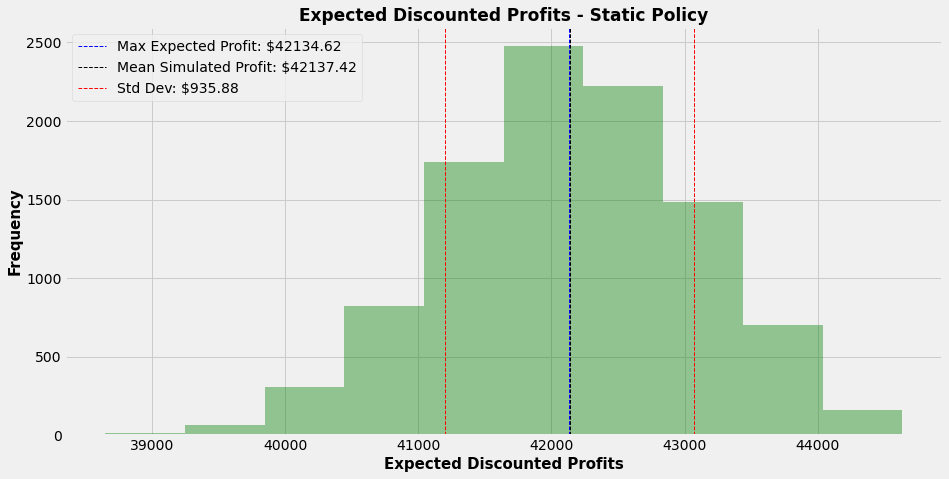

In [20]:
# histogram of discounted profits
plt.figure(figsize=(14, 7))
plt.hist(discounted_profits, bins = 10, color = 'green', alpha = 0.4)
plt.axvline(max_expected_profit, color='b', linestyle='dashed', linewidth=1, label='Max Expected Profit: ' + "${:.2f}".format(max_expected_profit))
plt.axvline(discounted_profits.mean(), color='k', linestyle='dashed', linewidth=1, label='Mean Simulated Profit: ' + "${:.2f}".format(discounted_profits.mean()))
plt.axvline(discounted_profits.mean() + discounted_profits.std(), color='r', linestyle='dashed', linewidth=1, label='Std Dev: '+ "${:.2f}".format(discounted_profits.std()))
plt.axvline(discounted_profits.mean() - discounted_profits.std(), color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.title('Expected Discounted Profits - Static Policy')
plt.xlabel('Expected Discounted Profits')
plt.ylabel('Frequency')
plt.show()

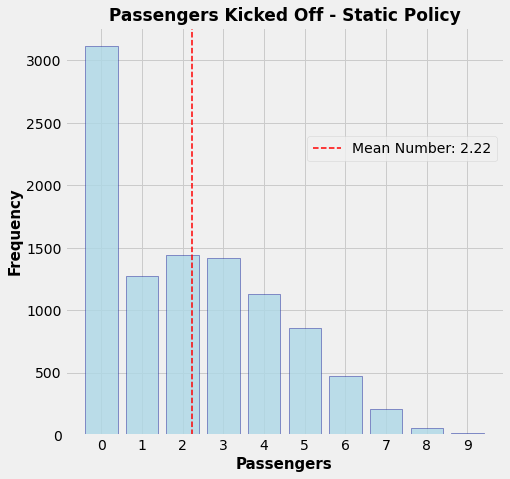

In [21]:
# count of each unique value in the num kicked array
kicked, kicked_counts = np.unique(num_kicked, return_counts=True)

# bar plot of the counts for num kicked
plt.figure(figsize=(7, 7))
plt.bar(kicked, kicked_counts, color = 'lightblue', alpha = 0.8, edgecolor = 'darkblue', linewidth = 0.5)
plt.title('Passengers Kicked Off - Static Policy')
plt.xlabel('Passengers')
plt.xticks(np.arange(0, int(max(num_kicked)) + 1, 1))
plt.ylabel('Frequency')
plt.axvline(num_kicked.mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean Number: ' + "{:.2f}".format(num_kicked.mean()))
plt.legend(loc = "upper right", bbox_to_anchor = (1.0, 0.75))
plt.show()

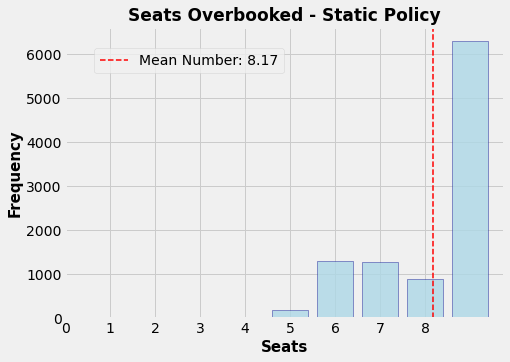

In [22]:
# plot of number of seats overbooked
overbooked, overbooked_counts = np.unique(num_overbooked, return_counts=True)

# bar plot of the counts for num overbooked
plt.figure(figsize=(7, 5))
plt.bar(overbooked, overbooked_counts, color = 'lightblue', alpha = 0.8, edgecolor = 'darkblue', linewidth = 0.5)
plt.title('Seats Overbooked - Static Policy')
plt.xlabel('Seats')
plt.xticks(np.arange(0, int(max(num_overbooked)), 1))
plt.ylabel('Frequency')
plt.axvline(num_overbooked.mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean Number: ' + "{:.2f}".format(num_overbooked.mean()))
plt.legend(loc = "upper left", bbox_to_anchor = (0.05, 0.95))
plt.show()

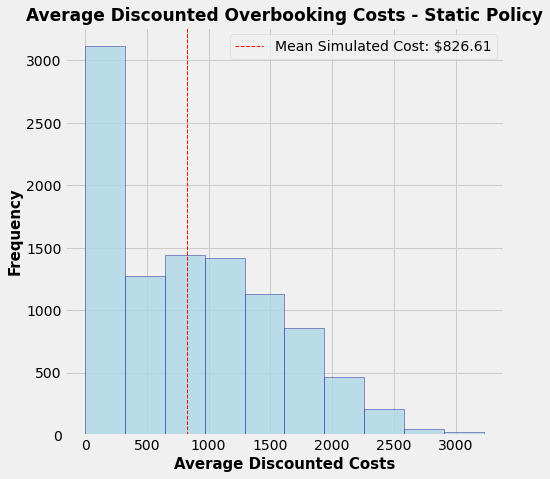

In [23]:
# histogram of discounted overbooking costs 
plt.figure(figsize=(7, 7))
plt.hist(avg_overbook_cost, bins = 10, color = 'lightblue', alpha = 0.8, edgecolor = 'darkblue', linewidth = 0.5)
plt.axvline(avg_overbook_cost.mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Simulated Cost: ' + "${:.2f}".format(avg_overbook_cost.mean()))
plt.legend()
plt.title('Average Discounted Overbooking Costs - Static Policy')
plt.xlabel('Average Discounted Costs')
plt.ylabel('Frequency')
plt.show()

In [24]:
# t test if the mean of the discounted profits is significantly different from the max expected profit
t_stat, p_val = ttest_1samp(discounted_profits, max_expected_profit)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)

t-statistic:  0.2994414487400966
p-value:  0.7646094643369801


In [25]:
# 95% confidence interval for the mean of the discounted profits
n = len(discounted_profits)
m = discounted_profits.mean()
std_err = discounted_profits.std() / np.sqrt(n)
margin_error = 1.96 * std_err
print("95% confidence interval: ", (m - margin_error, m + margin_error))

95% confidence interval:  (42119.07928609554, 42155.76582616003)


### Simulation for Method 2 - Dynamic Overbooking Policy

In [26]:
# set seed
# np.random.seed(5)

nsim = 10000

# establish vectors for each simulation 
coach_overbooked_vec = np.zeros(nsim)
coach_overbook_costs_incurred = np.zeros(nsim)
passenger_kicked_vect = np.zeros(nsim)
avg_overbook_cost = np.zeros(nsim)
discounted_profits = np.zeros(nsim)
num_overbooked = np.zeros(nsim)
num_kicked = np.zeros(nsim)

# loop through each simulation 
for sim in range(nsim):

    # initialize variables
    c = 0      # on the first day, 0 coach seats sold
    f = 0      # on the first day, 0 first-class seats sold
    tN = 365

    total_revenue = 0                      # we haven't made any money yet  
    coach_seats_sold_vec = np.zeros(tN)    # store how many c seats sold
    first_seats_sold_vec = np.zeros(tN)    # store how many f seats sold
    price_vec = np.zeros(tN)

    # loop forward in time
    for t in range(tN):                    # time = 0, 1, 2, ..., 364 (we make revenue then)  
        opt_price = U_dynamic[t, c, f]         
        price_vec[t] = opt_price

        # HH
        if opt_price == 1: 
            prob_sale_c = prob_coach_high[0]
            prob_sale_f = prob_first_high[0]
            actual_price_c = coach_high
            actual_price_f = first_high
        # HL
        elif opt_price == 2: 
            prob_sale_c = prob_coach_high[0]
            prob_sale_f = prob_first_low[0]
            actual_price_c = coach_high
            actual_price_f = first_low
        # LH
        elif opt_price == 3: 
            prob_sale_c = prob_coach_low[0]
            prob_sale_f = prob_first_high[0]
            actual_price_c = coach_low
            actual_price_f = first_high
        # LL
        elif opt_price == 4: 
            prob_sale_c = prob_coach_low[0]
            prob_sale_f = prob_first_low[0]
            actual_price_c = coach_low
            actual_price_f = first_low
        # NH
        elif opt_price == 5: 
            prob_sale_c = 0
            prob_sale_f = prob_first_high[0]
            actual_price_c = 0
            actual_price_f = first_high
        # NL
        elif opt_price == 6:  
            prob_sale_c = 0
            prob_sale_f = prob_first_low[0]
            actual_price_c = 0
            actual_price_f = first_low
        # HF ONLY
        elif opt_price == 7:  
            prob_sale_c = 0
            prob_sale_f = prob_first_high[0]
            actual_price_c = 0
            actual_price_f = first_high
        # LF ONLY
        elif opt_price == 8:  
            prob_sale_c = 0
            prob_sale_f = prob_first_low[0]
            actual_price_c = 0
            actual_price_f = first_low
        # HC ONLY
        elif opt_price == 9: 
            prob_sale_c = prob_coach_high_first_out[0]
            prob_sale_f = 0
            actual_price_c = coach_high
            actual_price_f = 0
        # LC ONLY
        elif opt_price == 10:
            prob_sale_c = prob_coach_low_first_out[0]
            prob_sale_f = 0
            actual_price_c = coach_low
            actual_price_f = 0
        # NC ONLY
        elif opt_price == 11:  
            prob_sale_c = 0
            prob_sale_f = 0
            actual_price_c = 0
            actual_price_f = 0
        # NO SALE
        else:               
            prob_sale_c = 0
            prob_sale_f = 0
            actual_price_c = 0
            actual_price_f = 0


        # toss coin with appropriate probability from above 
        sale_coach = (np.random.random(1) < prob_sale_c)        # True if sale, False if no sale
        sale_first = (np.random.random(1) < prob_sale_f)        # True if sale, False if no sale

        # update c and f
        c = int(c + sale_coach)
        f = int(f + sale_first)

        # update total profit
        total_revenue = total_revenue + (sale_coach * actual_price_c + sale_first * actual_price_f) * delta ** (t)    # add discounted revenue

        # save the results
        coach_seats_sold_vec[t] = c
        first_seats_sold_vec[t] = f
    
    # once exit the revenue simulator loop, we are at time T = 365 and need to simulate the day's costs
    # we have c and f and need to simulate how many people showed up to the flight on day T

    c_showup = np.random.binomial(c, prob_coach_show)    # number of coach seats filled
    f_showup = np.random.binomial(f, prob_first_show)    # number of first class seats filled
    
    # get the average overbooking cost
    cost = 0
    passenger_kicked = 0                       # number of passengers kicked off the flight
    
    if c > num_coach: 
        coach_overbooked_vec[sim] = 1              # track that we oversold in this simulation
        num_overbooked[sim] = c - num_coach        # track how many seats we oversold in this simulation

    if c_showup > num_coach:
        coach_overbook_costs_incurred[sim] = 1     # track that we incurred overbooking costs in this simulation     
        num_oversold = c_showup - num_coach        # number of seats oversold
        first_class_left = num_first - f_showup    # number of first class seats left
        
        # for each oversold seat, transfer to first class if possible, else bump off
        for value in range(num_oversold):
            if first_class_left > 0:
                cost += cost_upgrade
                first_class_left -= 1
            else:
                passenger_kicked += 1
                passenger_kicked_vect[sim] = 1
                cost += cost_bump_off

    # update passenger kicked off the flight vector
    num_kicked[sim] = passenger_kicked

    # discount cost back to time period 0
    cost = cost * delta ** (tN)
    
    avg_overbook_cost[sim] = cost

    # get the discounted profit
    discounted_profits[sim] = total_revenue - cost

In [27]:
# How often is coach overbooked?
print("Coach is overbooked ", np.mean(coach_overbooked_vec)*100, "% of the time.", sep = '')

# How often are overbooking costs incurred?
print("Overbooking costs are incurred ", np.mean(coach_overbook_costs_incurred)*100, "% of the time.", sep = '')

# How often are passengers kicked off the plane
print("Passengers are kicked off the plane ", np.mean(passenger_kicked_vect)*100, "% of the time.", sep = '')

# What is the average overbooking cost?
print("The average discounted overbooking cost is $", round(np.mean(avg_overbook_cost), 2), sep = '')

# What is the average discounted profit?
print("The average discounted profit is $", round(np.mean(discounted_profits), 2), sep = '')

# What is the volatility of the discounted profit?
print("The volatility of the discounted profit is $", round(np.std(discounted_profits), 2), sep = '')

# What is the average number of passengers kicked off the plane?
print("The average number of passengers kicked off the plane is ", round(np.mean(num_kicked), 2), sep = '')

# What is the average number of seats overbooked?
print("The average number of seats overbooked is ", round(np.mean(num_overbooked), 2), sep = '')

Coach is overbooked 100.0% of the time.
Overbooking costs are incurred 81.55% of the time.
Passengers are kicked off the plane 70.48% of the time.
The average discounted overbooking cost is $869.38
The average discounted profit is $42141.99
The volatility of the discounted profit is $943.81
The average number of passengers kicked off the plane is 2.33
The average number of seats overbooked is 8.37


In [28]:
# min and max discounted profit
print(round(max(discounted_profits), 2))
print(round(min(discounted_profits), 2))

44635.02
38576.99


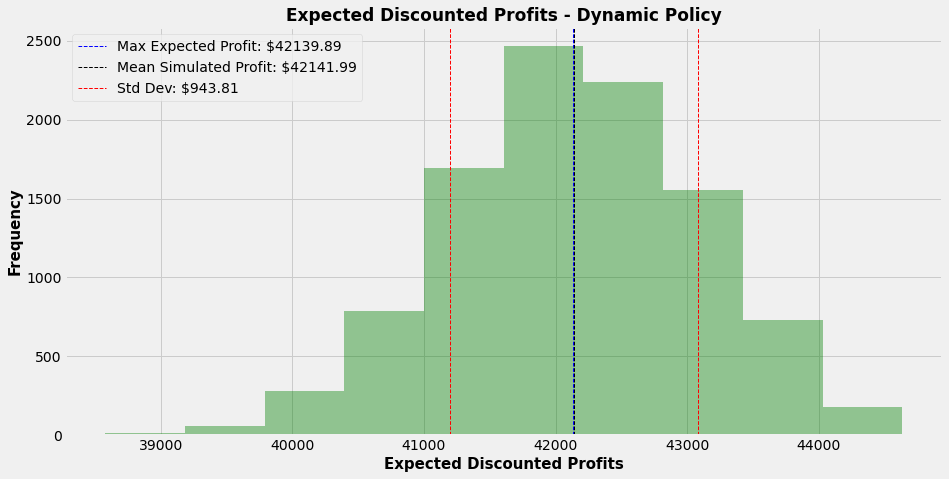

In [29]:
# histogram of discounted profits
plt.figure(figsize=(14, 7))
plt.hist(discounted_profits, bins = 10, color = 'green', alpha = 0.4)
plt.axvline(max_expected_profit, color='b', linestyle='dashed', linewidth=1, label='Max Expected Profit: ' + "${:.2f}".format(profit_dynamic))
plt.axvline(discounted_profits.mean(), color='k', linestyle='dashed', linewidth=1, label='Mean Simulated Profit: ' + "${:.2f}".format(discounted_profits.mean()))
plt.axvline(discounted_profits.mean() + discounted_profits.std(), color='r', linestyle='dashed', linewidth=1, label='Std Dev: '+ "${:.2f}".format(discounted_profits.std()))
plt.axvline(discounted_profits.mean() - discounted_profits.std(), color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.title('Expected Discounted Profits - Dynamic Policy')
plt.xlabel('Expected Discounted Profits')
plt.ylabel('Frequency')
plt.show()

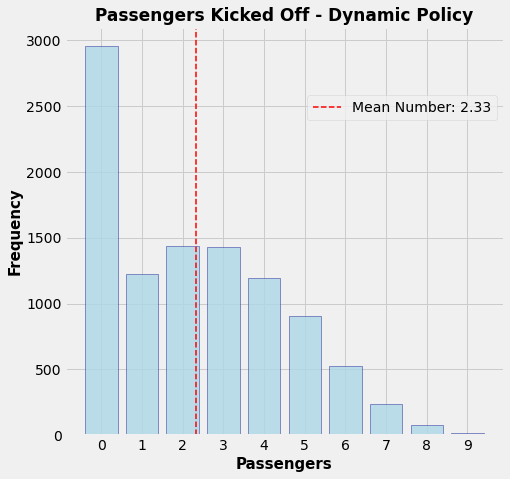

In [30]:
# count of each unique value in the num kicked array
kicked, kicked_counts = np.unique(num_kicked, return_counts=True)

# bar plot of the counts for num kicked
plt.figure(figsize=(7, 7))
plt.bar(kicked, kicked_counts, color = 'lightblue', alpha = 0.8, edgecolor = 'darkblue', linewidth = 0.5)
plt.title('Passengers Kicked Off - Dynamic Policy')
plt.xlabel('Passengers')
plt.xticks(np.arange(0, int(max(num_kicked)) + 1, 1))
plt.ylabel('Frequency')
plt.axvline(num_kicked.mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean Number: ' + "{:.2f}".format(num_kicked.mean()))
plt.legend(loc = "upper right", bbox_to_anchor = (1.0, 0.85))
plt.show()

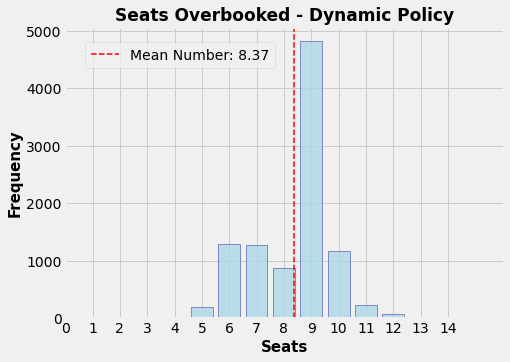

In [31]:
# number of seats overbooked
overbooked, overbooked_counts = np.unique(num_overbooked, return_counts=True)

# bar plot of the counts for num overbooked
plt.figure(figsize=(7, 5))
plt.bar(overbooked, overbooked_counts, color = 'lightblue', alpha = 0.8, edgecolor = 'darkblue', linewidth = 0.5)
plt.title('Seats Overbooked - Dynamic Policy')
plt.xlabel('Seats')
plt.xticks(np.arange(0, int(max(num_overbooked)), 1))
plt.ylabel('Frequency')
plt.axvline(num_overbooked.mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean Number: ' + "{:.2f}".format(num_overbooked.mean()))
plt.legend(loc = "upper left", bbox_to_anchor = (0.03, 0.97))
plt.show()

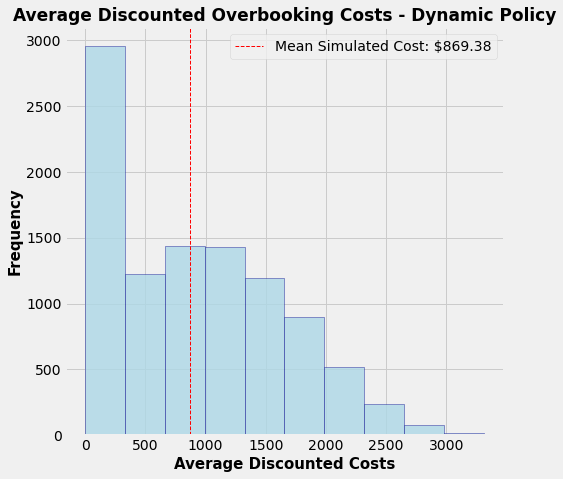

In [32]:
# histogram of discounted overbooking costs 
plt.figure(figsize=(7, 7))
plt.hist(avg_overbook_cost, bins = 10, color = 'lightblue', alpha = 0.8, edgecolor = 'darkblue', linewidth = 0.5)
plt.axvline(avg_overbook_cost.mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Simulated Cost: ' + "${:.2f}".format(avg_overbook_cost.mean()))
plt.legend()
plt.title('Average Discounted Overbooking Costs - Dynamic Policy')
plt.xlabel('Average Discounted Costs')
plt.ylabel('Frequency')
plt.show()

In [33]:
# t test if the mean of the discounted profits is significantly different from the max expected profit
t_stat, p_val = ttest_1samp(discounted_profits, profit_dynamic)
print("t-statistic: ", t_stat)
print("p-value: ", p_val)

t-statistic:  0.2226293340637298
p-value:  0.8238285513004239


In [34]:
# 95% confidence interval for the mean of the discounted profits
n = len(discounted_profits)
m = discounted_profits.mean()
std_err = discounted_profits.std() / np.sqrt(n)
margin_error = 1.96 * std_err
print("95% confidence interval: ", (m - margin_error, m + margin_error))

95% confidence interval:  (42123.492588635956, 42160.49002716417)
